In [47]:
from matplotlib import pyplot as plt
import numpy as np
from astropy.cosmology import LambdaCDM

(35.0, 50.0)

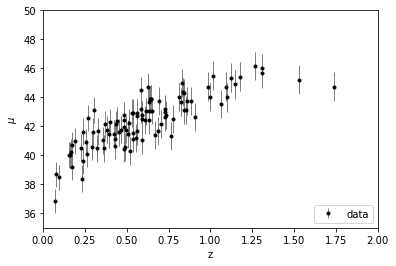

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

In [3]:
z = np.linspace(0.01, 2, 1000)

Let's do some cross validation

In [4]:
from sklearn.model_selection import train_test_split

mu = np.array([mu_sample, dmu]).T

z_train, z_val, mudmu_train, mudmu_val = train_test_split(z_sample[:, np.newaxis], mu, test_size=0.3, random_state=42)
mu_train, dmu_train = mudmu_train.T
mu_val, dmu_val = mudmu_val.T

In [10]:
def geterror(X, y, classifier):
    
    return np.sqrt( np.sum(( y - classifier.predict(X) )**2) / len(X) )

def fitanderror(classifier):
    
    classifier.fit(z_train, mu_train)
    error_train = geterror(z_train, mu_train, classifier)
    error_validation  = geterror(z_val, mu_val, classifier)
    return error_train, error_validation

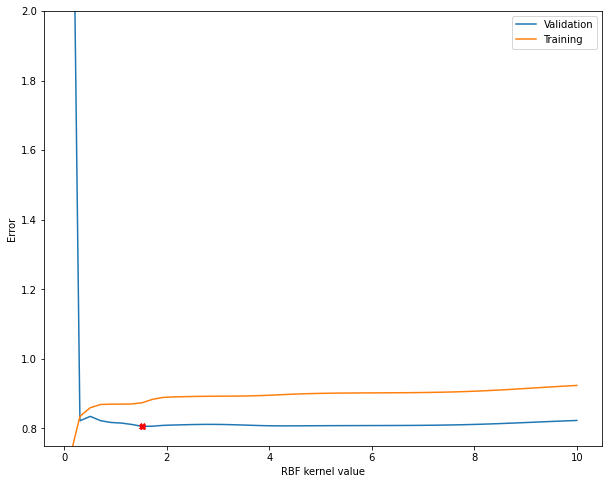

1.5142857142857145


In [29]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

kernels = np.linspace(0.1, 10)

fig = plt.figure(figsize=(10, 8))

err_train, err_test = [], []

for k in kernels:  
    
    kernel = RBF(k, length_scale_bounds='fixed')
    classifier = GaussianProcessRegressor(kernel=kernel, random_state=42, normalize_y=True, optimizer=None)
    error_train, error_validation = fitanderror(classifier)
    err_train.append(error_train)
    err_test.append(error_validation)
    
j = np.argmin(err_test)
x_min = kernels[j]
y_min = err_test[j]

plt.plot(kernels, err_test, label = 'Validation')
plt.plot(kernels, err_train, label = 'Training')
plt.plot(x_min, y_min, marker='X', c='r')

plt.xlabel('RBF kernel value')
plt.ylim(0.75, 2)
plt.ylabel('Error')
plt.legend(loc = 'best')
    
plt.show()
print(x_min)

In [40]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
kernel = RBF(1.5, length_scale_bounds='fixed')  # you can do ConstantKernel * RBF
gp = GaussianProcessRegressor(kernel=kernel, alpha = dmu**2, random_state=0, normalize_y=True, optimizer=None)
gp.fit(z_sample[:, np.newaxis], mu_sample)
y_pred, dy_pred = gp.predict(z[:, np.newaxis], return_std=True)

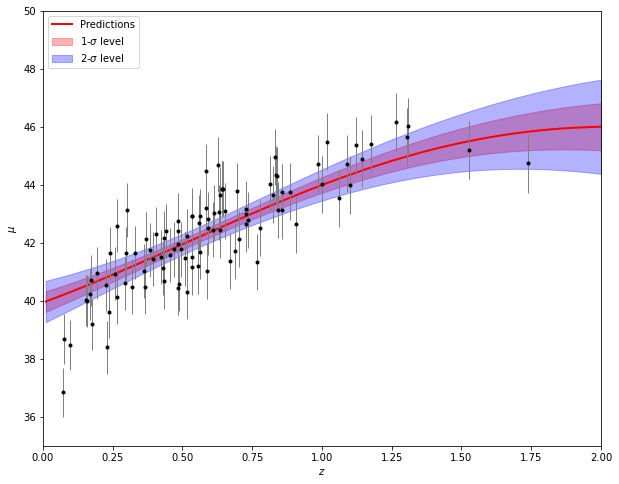

In [41]:
fig = plt.figure(figsize=(10, 8))
plt.plot(z, y_pred, "-r", linewidth=2, label="Predictions")
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
plt.fill_between(z, y_pred - dy_pred, y_pred + dy_pred, color='red', alpha=0.3, label = '1-$\\sigma$ level')
plt.fill_between(z, y_pred - 2 * dy_pred, y_pred + 2 * dy_pred, color='blue', alpha=0.3, label = '2-$\\sigma$ level')
plt.xlabel("$z$")
plt.ylabel("$\mu$")
plt.legend(loc="upper left")
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

Let's do some parameter estimation

In [ ]:
# do the emcee thing, nested sampling or emcee with savage dickey
# you can redo all without the two high redshift points
# you can clone data through the right distribution of redshift (not uniform)

In [42]:
import emcee
import scipy.stats as scistats
import corner
import dynesty

C:\Users\loren\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\loren\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [43]:
def generativemodel(z, H0, Om=1):
    cosmo_tmp = LambdaCDM(H0=H0, Om0=Om, Ode0=1-Om)
    return cosmo_tmp.distmod(z).value

In [45]:
def LogLikelihood(theta):
    Om,H0 = theta    
    if Om<0:
        return -np.inf
    else:
        mu_model = generativemodel(z_sample, H0, Om)
    
    return np.sum(scistats.norm(loc=mu_model, scale=dmu).logpdf(mu_sample))

def log_prior(theta):
    Om,H0 = theta
    if 0.1 < Om < 1 and 50.0 < H0 < 100.0:
        return 0.0
    
    return -np.inf

def log_posterior(theta):
    return LogLikelihood(theta) + log_prior(theta)

In [57]:
nsteps = int(1e4)
nwalkers, ndim = 5, 2
starting_guess = np.array([0.5, 50]) + 1e-1 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(starting_guess, nsteps);

C:\Users\loren\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


emcee: Exception while calling your likelihood function:
  params: [ 0.43598602 64.32250088]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "C:\Users\loren\anaconda3\lib\site-packages\emcee\ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "C:\Users\loren\AppData\Local\Temp\ipykernel_11556\1845667997.py", line 18, in log_posterior
    return LogLikelihood(theta) + log_prior(theta)
  File "C:\Users\loren\AppData\Local\Temp\ipykernel_11556\1845667997.py", line 6, in LogLikelihood
    mu_model = generativemodel(z_sample, H0, Om)
  File "C:\Users\loren\AppData\Local\Temp\ipykernel_11556\2824941331.py", line 3, in generativemodel
    return cosmo_tmp.distmod(z).value
  File "C:\Users\loren\anaconda3\lib\site-packages\astropy\cosmology\flrw.py", line 1280, in distmod
    val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0
  File "C:\Users\loren\anaconda3\lib\site-packages\astropy\cosmology\flrw.py", line 1201, in luminosity_distance
    return (z + 1.0) * self.comoving_transverse_distance(z)
  File "C:\Users\loren\anaconda3\lib\site

KeyboardInterrupt: 

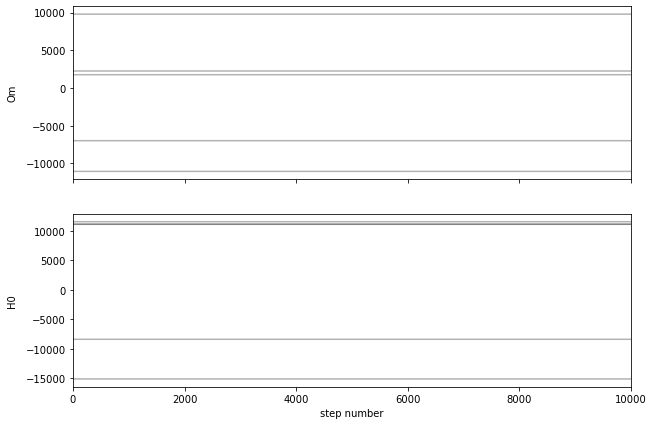

In [55]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels_param = ["Om", "H0"] 
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels_param[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [56]:
tau = sampler.get_autocorr_time()
print(tau)

[nan nan]


C:\Users\loren\anaconda3\lib\site-packages\emcee\autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]
